## P1) Sonar rock project

Let's work through this ML exercise to help distinguish rocks from mines.

To start, we downloaded the dataset from the UCI website (http://archive.ics.uci.edu/ml/datasets/connectionist+bench+(sonar,+mines+vs.+rocks)#:~:text=Data%20Set%20Information%3A,from%20rocks%20under%20similar%20conditions.) and converted to CSV.

In [80]:
import pandas as pd
import numpy as np

columns = ['Angle_'+str(i) for i in range(1,61)]
columns.append('Result')

df = pd.read_csv('sonar.csv', header = 0, names = columns)

df.head(3)

,Angle_1,Angle_2,Angle_3,Angle_4,Angle_5,Angle_6,Angle_7,Angle_8,Angle_9,Angle_10,...,Angle_52,Angle_53,Angle_54,Angle_55,Angle_56,Angle_57,Angle_58,Angle_59,Angle_60,Result
0,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
1,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
2,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R


### Data exploration


Now that we have our data, let's have a bit of a look at it and see if there are any gaps, and what it looks like in general.

In [84]:
df.shape #207 rows, 61 columns
df.dtypes #All floats, except for final classification which is an object. Might be some value in converting
          #to values later.
df.info #All non-null, so no need for cleaning
df.describe() #Wild variation in means, mins and maxs (within a range of maybr 0 - 1). Might need to do some
#               #transformations or standardisation to get the data more cooperative
df.groupby('Result').size() #111 mines, 96 rocks, so equal enough that accuracy will probably be a pretty
                            #decent metric, among other things


Result
M    111
R     96
dtype: int64

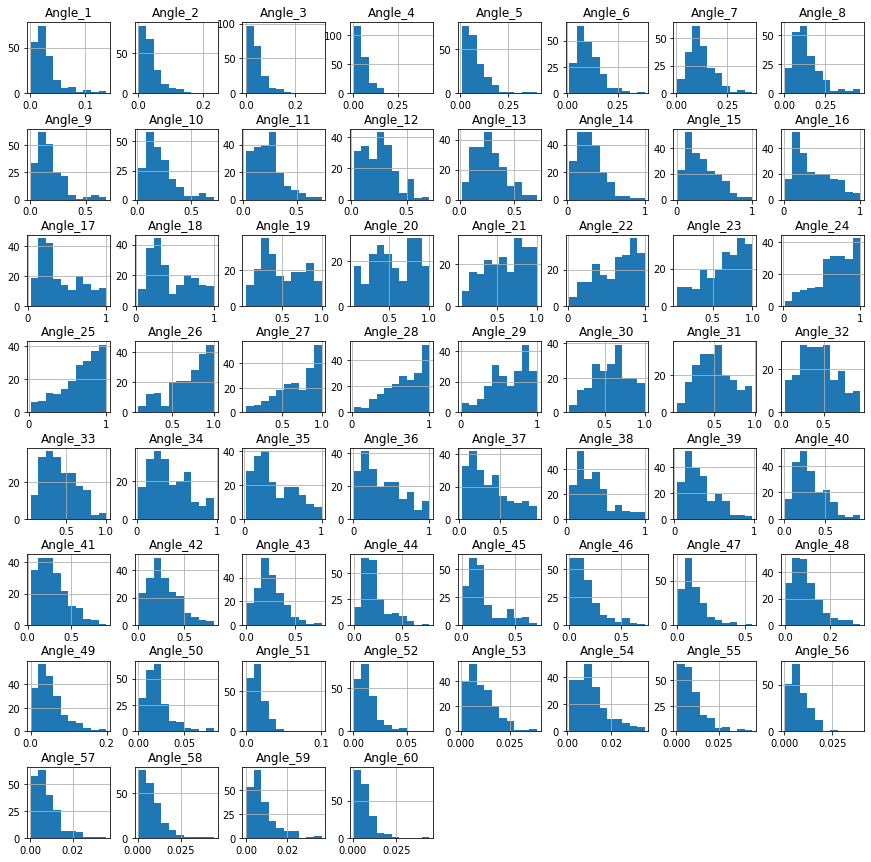

In [3]:
#Let's check distributions

from matplotlib import pyplot as plt

df.hist(figsize = (15,15))
plt.subplots_adjust(hspace = 0.5)
plt.show()

#We can see that the distribution of many of these angles is in fact exponential and even bimodal.
#There also seems to be very long tails and outliers. There might be some value in standardising or transforming.

<AxesSubplot:>

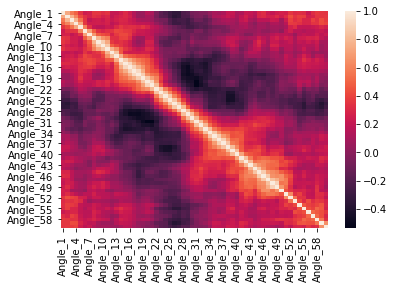

In [4]:
import seaborn as sns

sns.heatmap(df.corr())
# df.corr()

By the looks of things, there are some degree of correlation between very close angles (i.e. 1 is highly correlated with 2, 48 is correlated with 49, etc.). We could try thinning some of the variables out a bit later.

So some thoughts of what we can play around with later is:
- Standardising the data
- Transforming it
- Thinning out highly correlated variables


In [5]:
df_conv = df.copy()

#Convert M to 1 and R to 0 since that can be helpful for algorithms
df_conv['Result'] =  np.where(df_conv['Result'] == 'M',1,0)

df_conv.groupby('Result').size() 

Result
0     96
1    111
dtype: int64

### Analysis of key features

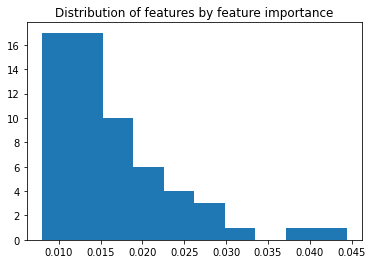

In [6]:
from sklearn.ensemble import ExtraTreesClassifier

X = df_conv.iloc[:, 0:-1]
Y = df_conv['Result']

model = ExtraTreesClassifier()
model.fit(X,np.ravel(Y))
# print(min(model.feature_importances_), max(model.feature_importances_), (model.feature_importances_).mean())

plt.hist(model.feature_importances_)
plt.title('Distribution of features by feature importance')
plt.show()
#Honestly the contributions aren't astronomically different, probably best to keep them in there.

### Test some algorithms

We'll have a few runs of the data, first unchanged, then with some transformations or standardisation.

In [7]:
#Transformations

from sklearn.model_selection import KFold, cross_val_score
# from sklearn.pipeline import Pipeline
# In this instance there's not much use for the Pipeline library

#Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression #NEEDS standardisation
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split

X = df_conv.iloc[:, 0:-1]
Y = df_conv['Result']

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size = 0.8, random_state = 6)

#Set up models
models = []

models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))     
models.append(('SVC', SVC()))              
models.append(('Trees', DecisionTreeClassifier()))              
models.append(('KNN', KNeighborsClassifier()))              
models.append(('Random forest', RandomForestClassifier()))
models.append(('ADA booster', AdaBoostClassifier()))           
models.append(('Gradient booster', GradientBoostingClassifier()))           

names = []
results = []

for name, result in models:
    kfold = KFold(n_splits = 10, random_state = 7, shuffle = True)
    cv_results = cross_val_score(model, X_train, y_train, cv = kfold, scoring = 'accuracy')
    
    #Grab these for plotting
    names.append(name)
    results.append(cv_results)
    
    print(f'{name}: Accuracy of {round(cv_results.mean(),2)*100}% (std: {round(cv_results.std(),4)})')
    

LR: Accuracy of 90.0% (std: 0.0543)
LDA: Accuracy of 88.0% (std: 0.0457)
SVC: Accuracy of 86.0% (std: 0.0652)
Trees: Accuracy of 89.0% (std: 0.0648)
KNN: Accuracy of 89.0% (std: 0.0526)
Random forest: Accuracy of 89.0% (std: 0.0534)
ADA booster: Accuracy of 86.0% (std: 0.0373)
Gradient booster: Accuracy of 87.0% (std: 0.0576)


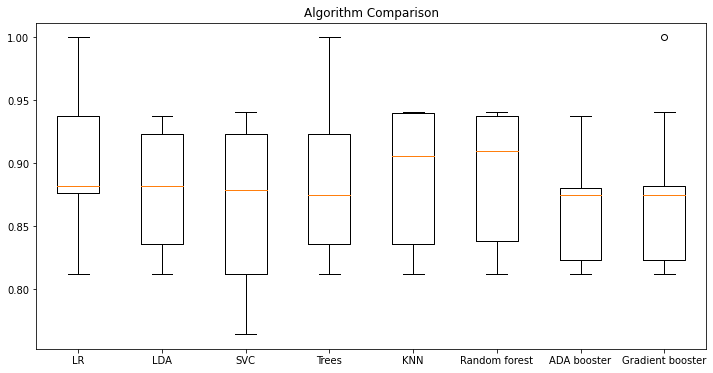

In [8]:
plt.figure(figsize = (12,6))
ax = plt.subplot()

plt.boxplot(results)

plt.title('Algorithm Comparison')
ax.set_xticklabels(names)

plt.show()

From the results the models are all pretty similar with some minor variation between them. Let's try some standardisation and transformation to see if that has any effect.

In [85]:
from sklearn.preprocessing import StandardScaler, Normalizer

#This creates a scaler object based off the data in X.
#VERY IMPORTANT: best practise is to scale the data off of the train data
#(like we are doing here) and use that to transform the test data later

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size = 0.8, random_state = 6)

scaler = StandardScaler().fit(X_train)
# scaler = Normalizer().fit(X_train)
rescaled_x = scaler.transform(X_train)

names = []
results = []

#Set up models
models = []

models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))     
models.append(('SVC', SVC()))              
models.append(('Trees', DecisionTreeClassifier()))              
models.append(('KNN', KNeighborsClassifier()))              
models.append(('Random forest', RandomForestClassifier()))
models.append(('ADA booster', AdaBoostClassifier()))           
models.append(('Gradient booster', GradientBoostingClassifier()))   

for name, result in models:
    kfold = KFold(n_splits = 10, random_state = 7, shuffle = True)
    cv_results = cross_val_score(model, rescaled_x, y_train, cv = kfold, scoring = 'accuracy')
    
    #Grab these for plotting
    names.append(name)
    results.append(cv_results)
    
    print(f'{name}: Accuracy of {round(cv_results.mean(),2)*100}% (std: {round(cv_results.std(),4)})')

LR: Accuracy of 84.0% (std: 0.0763)
LDA: Accuracy of 87.0% (std: 0.0699)
SVC: Accuracy of 86.0% (std: 0.0404)
Trees: Accuracy of 83.0% (std: 0.0687)
KNN: Accuracy of 87.0% (std: 0.0647)
Random forest: Accuracy of 86.0% (std: 0.0683)
ADA booster: Accuracy of 86.0% (std: 0.0482)
Gradient booster: Accuracy of 86.0% (std: 0.0834)


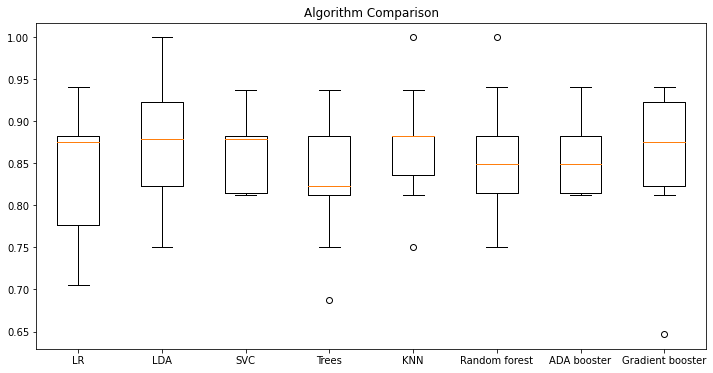

In [86]:
plt.figure(figsize = (12,6))
ax = plt.subplot()

plt.boxplot(results)

plt.title('Algorithm Comparison')
ax.set_xticklabels(names)

plt.show()

Standardising and normalising didn't seem to make much of a difference to be honest. Let's try transforming it. Most of the graphs were right skewed.

In [11]:
X.skew().mean()

0.9690195277770972

...as seen by the above. Using the sqrt is a good way to reduce this skewness.

In [87]:
logged_X = np.sqrt(X)

logged_X.skew().mean()

#This worked. Now, let's try again.

0.1171409965214243

In [88]:
X_train, X_test, y_train, y_test = train_test_split(logged_X, Y, train_size = 0.8, random_state = 6)

names = []
results = []

for name, result in models:
    kfold = KFold(n_splits = 10, random_state = 7, shuffle = True)
    cv_results = cross_val_score(model, X_train, y_train, cv = kfold, scoring = 'accuracy')
    
    #Grab these for plotting
    names.append(name)
    results.append(cv_results)
    
    print(f'{name}: Accuracy of {round(cv_results.mean(),2)*100}% (std: {round(cv_results.std(),4)})')

LR: Accuracy of 85.0% (std: 0.0593)
LDA: Accuracy of 84.0% (std: 0.0776)
SVC: Accuracy of 86.0% (std: 0.0594)
Trees: Accuracy of 84.0% (std: 0.065)
KNN: Accuracy of 85.0% (std: 0.055)
Random forest: Accuracy of 88.0% (std: 0.0593)
ADA booster: Accuracy of 87.0% (std: 0.0821)
Gradient booster: Accuracy of 84.0% (std: 0.0881)


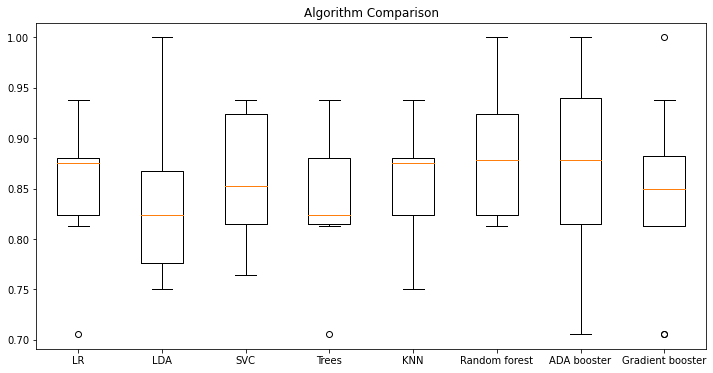

In [89]:
plt.figure(figsize = (12,6))
ax = plt.subplot()

plt.boxplot(results)

plt.title('Algorithm Comparison')
ax.set_xticklabels(names)

plt.show()

All things being the same, it looks like SVC with sqrted data technically got best results.

Let's concentrate to see whether tuning hyper-parameters accomplishes anything for it.

### Tuning SVC

In [15]:
from sklearn.model_selection import GridSearchCV

logged_X = np.sqrt(X)

X_train, X_test, y_train, y_test = train_test_split(logged_X, Y, train_size = 0.8, random_state = 6)

param_grid = {'C': [1,5,10],
              'gamma': [1,2,2.5],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

grid = GridSearchCV(SVC(), param_grid, refit = True)

grid.fit(X_train, y_train)

print("Our best parameters are:", grid.best_params_)
print("Our best estimation is:",grid.best_estimator_)

#First run, {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
#Second run, {'C': 5, 'gamma': 2, 'kernel': 'rbf'}
#Third run, {'C': 1, 'gamma': 2.5, 'kernel': 'rbf'}

Our best parameters are: {'C': 1, 'gamma': 2.5, 'kernel': 'rbf'}
Our best estimation is: SVC(C=1, gamma=2.5)


SVC: Accuracy of 91.0% (std: 0.0418)


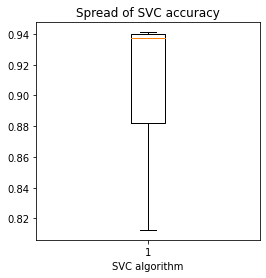

In [16]:
kfold = KFold(n_splits = 10, random_state = 7, shuffle = True)
cv_results = cross_val_score(SVC(C = 1, gamma = 2.5, kernel = 'rbf'), X_train, y_train, cv = kfold, scoring = 'accuracy')

print(f'SVC: Accuracy of {round(cv_results.mean(),2)*100}% (std: {round(cv_results.std(),4)})')

plt.figure(figsize = (4,4))
ax = plt.subplot()

plt.boxplot(cv_results)

plt.title('Spread of SVC accuracy')
plt.xlabel('SVC algorithm')
# ax.set_xticklabels('SVC algorithm')

plt.show()

Now we can finalise our model by applying it to the test set.

In [17]:
from sklearn.metrics import (accuracy_score, recall_score, precision_score,
f1_score, classification_report, confusion_matrix)

the_machine = SVC(C = 1, gamma = 2.5, kernel = 'rbf')
the_machine.fit(X_train, y_train)
prediction = the_machine.predict(X_test)

print(accuracy_score(prediction, y_test),
recall_score(prediction, y_test),
precision_score(prediction, y_test),
f1_score(prediction, y_test))

print(classification_report(y_test, prediction))

print(confusion_matrix(prediction, y_test))

0.8809523809523809 0.875 0.9130434782608695 0.8936170212765957
              precision    recall  f1-score   support

           0       0.89      0.84      0.86        19
           1       0.88      0.91      0.89        23

    accuracy                           0.88        42
   macro avg       0.88      0.88      0.88        42
weighted avg       0.88      0.88      0.88        42

[[16  2]
 [ 3 21]]


Scores of about 88-90%...nice! 

### Aftermath: Some addition feature tweaking just for interest's sake

* Let's try thinning out the features in the dataset since close ones were highly correlated.
* Then let's try transforming the data with a little more mathematical rigour.

SVC: Accuracy of 88.0% (std: 0.0897)


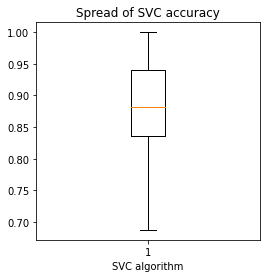

In [41]:
#Let's try thinning the features

neo_X = X.copy()

all_col = X.columns
count = 3

for i in range(len(X.columns)):
    if count % 2 == 0:
        neo_X = neo_X.drop([all_col[i]], axis = 1)
    count += 1

logged_neo_X = np.sqrt(neo_X)

X_train, X_test, y_train, y_test = train_test_split(logged_neo_X, Y, train_size = 0.8, random_state = 6)

#From testing, best results are 'C': 22, 'gamma': 1, 'kernel': 'rbf'

# param_grid = {'C': [20,21,22,23,24],
#               'gamma': [0.6,0.7,0.8,0.9, 1, 1.1,1.2,1.3],
#               'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

# grid = GridSearchCV(SVC(), param_grid, refit = True)

# grid.fit(X_train, y_train)

# print("Our best parameters are:", grid.best_params_)
# print("Our best estimation is:",grid.best_estimator_)

kfold = KFold(n_splits = 10, random_state = 7, shuffle = True)
cv_results = cross_val_score(SVC(C = 22, gamma = 1, kernel = 'rbf'), X_train, y_train, cv = kfold, scoring = 'accuracy')

print(f'SVC: Accuracy of {round(cv_results.mean(),2)*100}% (std: {round(cv_results.std(),4)})')

plt.figure(figsize = (4,4))
ax = plt.subplot()

plt.boxplot(cv_results)

plt.title('Spread of SVC accuracy')
plt.xlabel('SVC algorithm')
plt.show()

SVC: Accuracy of 86.0% (std: 0.0533)


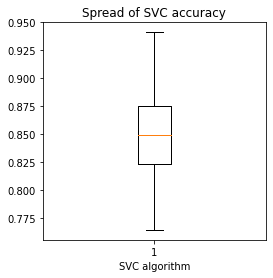

In [79]:
#Let's try transfomring based on skewedness

skewedness = X.skew()

fino_X = X.copy()
all_col = X.columns

for i in range(len(X.columns)):
    if skewedness[i] > 0.5:
        fino_X[all_col[i]] = np.sqrt(fino_X[all_col[i]])
    elif skewedness[i] < -0.5:
        fino_X[all_col[i]] = fino_X[all_col[i]]**2
        
X_train, X_test, y_train, y_test = train_test_split(fino_X, Y, train_size = 0.8, random_state = 6)

kfold = KFold(n_splits = 10, random_state = 7, shuffle = True)
cv_results = cross_val_score(SVC(C = 1, gamma = 2.5, kernel = 'rbf'), X_train, y_train, cv = kfold, scoring = 'accuracy')

print(f'SVC: Accuracy of {round(cv_results.mean(),2)*100}% (std: {round(cv_results.std(),4)})')

plt.figure(figsize = (4,4))
ax = plt.subplot()

plt.boxplot(cv_results)

plt.title('Spread of SVC accuracy')
plt.xlabel('SVC algorithm')
plt.show()